# Relevant imports

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from scipy.signal import argrelextrema
import math
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import sys
import os,glob
import yaml
from chainconsumer import ChainConsumer
from scipy.special import gamma
from scipy.optimize import fsolve
from scipy.interpolate import interp1d  
import pandas as pd
import matplotlib.ticker as ticker

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.size']=13
plt.rcParams['font.family']='stix'
plt.rcParams['text.usetex']=True
plt.rcParams['figure.figsize']= (6.5,4)
plt.rcParams['figure.dpi']=150

---

---

---

# Semi-analytical functions

#### Various constants

http://pdg.lbl.gov/2014/reviews/rpp2014-rev-astrophysical-constants.pdf

https://arxiv.org/pdf/1904.10000

https://arxiv.org/pdf/1502.01589.pdf

In [2]:
# Constants
h = 0.6727
H0=67.27
Omega_m = (0.1199)/(h**2)
Omega_b = 0.05
Omega_rad=10e-5
p_crit=4.755e-6
rho_crit = 1.256*10**11*Omega_m
p_b = Omega_b*p_crit
T0 = 2.7255
kb = 8.617333262145e-5
T_0 = kb*T0*1e-9
m_p=0.93827231
Y_p=0.75

# Factors to satisfy units
k_crit_conversionFactor=3.33333333e-6
R_x_conversionFactor=9.258e29

# Mass/sigma arrays
masses = np.array([1e-4,1e-3,1e-2,1e-1,1.,10.])
sigma = np.zeros(len(masses))
sigma_array = np.logspace(-10,-30,200)

#### Relevant functions

https://arxiv.org/pdf/1801.08609.pdf

$ N_0 =  2^{(5+n)/2}\Gamma(3+n/2)/(3\sqrt{\pi})$

In [3]:
def N_0(n):
    return pow(2,(5.+n)/2.)*gamma(3.+n/2.)/(3.*np.sqrt(np.pi))

http://sro.sussex.ac.uk/id/eprint/46339/1/MNRAS-2012-Schneider-684-98.pdf

$M_{hm} = \frac{4\pi\bar{\rho}}{3}\big(\frac{\lambda_{hm}}{2}\big)^3$

$\qquad = \frac{4\pi\bar{\rho}}{3}\big(\frac{\pi}{hk_{hm}}\big)^3$

$\therefore k_{hm} = \frac{\pi}{h}\big(\frac{4\pi\bar{\rho}}{3M_{hm}}\big)^{1/3}$

In [4]:
def mhm2khm(Mhm):
    return np.pi/h*(((4.*np.pi*rho_crit)/(3*Mhm))**(1./3.))

https://arxiv.org/pdf/1808.00001.pdf

$R_x = \frac{N_0a\rho_bY_p\sigma_0}{m_{\chi}+m_p}\Big(\frac{T_b}{m_p}+\frac{T_{\chi}}{m_{\chi}}\Big)^{\frac{1+n}{2}}$


In [5]:
def R_x(sigma_0, m_x, n):
    return N_0(n)*Y_p*p_b*R_x_conversionFactor*(sigma_0/(m_x+m_p))*(pow((T_0/m_x)+(T_0/m_p),((1.+n)/2.)))

https://arxiv.org/pdf/1904.10000

$aH = R_{\chi}(m_{\chi}/(m_{\chi}+m_p))$

Note that $aH \sim z$ and $R_{\chi} \sim z^{n+5/2}$ such that

$zH_0\sqrt{\Omega_{rad}} = R_{\chi}(m_{\chi}/(m_{\chi}+m_p))z^{n+5/2}$

$\therefore z = ((m_{\chi}+m_p)H_0\sqrt{\Omega_{rad}}/R_{\chi}m_{\chi})^{2/n+3}$

In [6]:
def z_th(sigma_0,m_x,n):
    return ((H0*np.sqrt(Omega_rad)*(m_x+m_p))/(R_x(sigma_0,m_x,n)*m_x))**(2./(n+3.))

https://arxiv.org/pdf/1904.10000

$aH = R_{\chi} = \frac{N_0a\rho_bY_p\sigma_0}{m_{\chi}+m_p}\Big(\frac{T_b}{m_p}+\frac{T_{\chi}}{m_{\chi}}\Big)^{\frac{1+n}{2}}$

Note that $aH \sim z$, $a\bar{\rho} \sim z^2$, $T_b \sim z$ and $T_{\chi} \sim z^2/z_{th}$, such that

$\frac{H_0\sqrt{\Omega_{rad}}(m_{\chi}+m_p)}{N_0Y_p\rho_b\sigma_0} = z^2/z \big(\frac{T_0z}{m_p}+\frac{T_0z^2}{z_{th}m_{\chi}}\big)^{n+1/2}$

$0 = z \big(\frac{T_0z}{m_p}+\frac{T_0z^2}{z_{th}m_{\chi}}\big)^{n+1/2} - \frac{H_0\sqrt{\Omega_{rad}}(m_{\chi}+m_p)}{N_0Y_p\rho_b\sigma_0}$

Solving the above for $z$ yields $z_{kin}$

In [7]:
def z_kin(sigma_0,m_x,n):
    return fsolve(lambda z: z * ((T_0*z**2)/(z_th(sigma_0,m_x,n)*m_x) + (T_0*z_th(sigma_0,m_x,n))/m_p)**((n+1.)/2.) - (H0*np.sqrt(Omega_rad)/(N_0(n)*Y_p*p_b*R_x_conversionFactor))*(m_x+m_p)/sigma_0,z_th(sigma_0,m_x,n)/2.)    

https://arxiv.org/pdf/1904.10000

$k_{crit} = 2aH = 2H_0\sqrt{\Omega_{rad}}z_{kin}^2/z_{kin} = 2H_0\sqrt{\Omega_{rad}}z_{kin}$

In [8]:
# Equation 4
def sigma2k(sigma_0,m_x,n):
    return 2.*(H0*np.sqrt(Omega_rad)*z_kin(sigma_0,m_x,n))*3.33e-6

$\sigma_0$ $limits$

In [9]:
def sig(klimit,n):
    sigma = []
    for i in range(len(masses)):
        sigma.append(sigma_array[np.argmin(np.abs(sigma2k(sigma_array,masses[i],n)-h*klimit))])
    return np.array(sigma)

def sigma_vs_mx(klimit):
    return hv.Curve((masses, sig(klimit)))

---

---

---

# Numerical functions

In [314]:
masses_test = [1e-4,1e-3,1e-2,1e-1,1.,10.]
smallSigs = np.logspace(-20,-30,100)
largeSigs = np.logspace(-10,-30,100)

#### Generate inis

In [321]:
def make_inis(ini_base_file='class/inis/dmeff_base.ini',base_inis_path='class/inis/',class_runner_path = 'class/',npow=0,masses=masses_test,sigmas=smallSigs,output_path='pk_output',sh_file='class/run_classes.sh'):
    
    fin =  open(ini_base_file, 'r')
    base_content = fin.read()
    fin.close()
    fout_sh = open(class_runner_path+'run_classes.sh', 'w')

    for m in masses:
#         if npow>2 and m>1:
#             sigmas = largeSigs
#         else:
#             sigmas = smallSigs
        for sigma in sigmas:
            filename = 'n{}_m{}_s{}.ini'.format(npow,m,sigma)
            fout_sh.write('./class ' + 'inis/{}\n'.format(filename))
            fout = open(base_inis_path + filename, 'w')
            fout.write(base_content)
            fout.write('\n')
            npow_line = 'npow_dmeff = {}\n'.format(npow)
            fout.write(npow_line)
            m_line = 'm_dmeff = {}\n'.format(m)
            fout.write(m_line)
            sigma_line = 'sigma_dmeff = {}\n'.format(sigma)
            fout.write(sigma_line)
            if npow<0:
                vel_line = 'Vrel_dmeff_rate = 30\n' #sets to DBK case.
                fout.write(vel_line)
            root_line = 'root = {}/n{}_m{}_s{}_\n'.format(output_path,npow,m,sigma)
            fout.write(root_line)
            
    fout_sh.close()

In [351]:
make_inis(npow=2,masses=[1])

From the command line, run:

chmod +x run_classes.sh

bash run_classes.sh

$\sigma_0$ $limits$

In [188]:
def calculate_kcuts(npow=0, m=1e-3, z='z1',sigmas=smallSigs, pk_root='class/pk_output/', upper_cut=66, lower_cut=1, reduction_factor=0.75):
    
    data0 = np.loadtxt('class/pk_output/lcdm_z1_pk_130.dat')
    ks = data0[:,0]
    pk0 = data0[:,1]
    
    khms = []
    ss = []
        
    for i,sigma in enumerate(sigmas):
        try:
            data = np.loadtxt(pk_root + 'n{}_m{}_s{}_{}_pk.dat'.format(npow,m,sigma,z))
            pk = data[:,1]
            print(m,pk.shape,pk0.shape)
            ind = (np.abs(np.abs((pk0-pk)/pk0) - reduction_factor)).argmin()
            if ks[ind]>upper_cut or ks[ind]<lower_cut:
                continue
            khms.append(ks[ind])
            ss.append(sigmas[i])
        except:
            continue
    
    try:
        p = np.polyfit(np.log10(ss), np.log10(khms), 1)
    except:
        return -1
    
    return np.array(ss),np.array(khms),p

In [14]:
def fit_fun(x,p):
    pp = p[0]*np.log10(x) + p[1]
    return np.power(10,pp)

In [44]:
def sigma0_limit(kcut, masses=masses_test,
                npow=0, z=0,reduction_factor=0.25,
                ymax=1e-26,ymin=1e-31,plot_ks=True):
    
    masses = np.array(masses)
    sigmas = np.zeros(len(masses))

    for i,m in enumerate(masses):
        ks_filename = 'data/ks_{}_z{}_n{}_m{}.txt'.format(reduction_factor,z,npow,m)
#         try: 
        np.loadtxt(ks_filename)
#         except:
#             continue
        data = np.loadtxt(ks_filename)
        ss = data[:,0]
        ks = data[:,1]
        p = np.polyfit(np.log10(ks), np.log10(ss), 1)
        sigmas[i] = fit_fun(kcut,p)
                  
    return masses,sigmas

#### $T(k)_{idm}$

In [16]:
def findLocalMins(arr):
    mins = []
    i=0
    while i < len(arr):
        try:
            if (arr[i-3]-arr[i])>0.01 and (arr[i+3]-arr[i])>0.01:
                mins.append(i)
                i+=3
            i+=1
        except:
            i+=1
            continue
         
    return mins

In [17]:
def findLocalMaxs(arr):
    maxs = []
    i=0
    while i < len(arr):
        try:
            if (arr[i]-arr[i-3])>0.01 and (arr[i]-arr[i+3])>0.01:
                maxs.append(i)
                i+=3
            i+=1
        except:
            i+=1
            continue
                
    return maxs

In [108]:
def tk(npow=0,m=0.0001,plotPeaks=False,colorbar=False,singleSigma=False,index=0,sigmas=smallSigs,z='z1',pk_root='class/pk_output/',filename=None,lcdm_filename='lcdm_z1_pk.dat',label='',f=None,ax=None,xmin=0,xmax=20,ymin=-1.0,ymax=1e3,show_kcut=True,pfit=None, relative=True,boost_factor=1.):

    data0 = np.loadtxt('class/pk_output/lcdm_z1_pk.dat')
    ks = data0[:,0]
    pk0 = data0[:,1]
    
    k1 = []
    k2 = []
    sigs = []
    peaks2D = []
    
    colors = [(math.sqrt((90.+1.))/10,1-math.sqrt((90.+1.))/10,1-math.sqrt((90.+1.))/10),(math.sqrt((1.))/10,1-math.sqrt((1.))/10,1-math.sqrt((1.))/10)]  # R -> G -> B
    n_bins = [100]  # Discretizes the interpolation into bins
    cm = LinearSegmentedColormap.from_list('cm', colors, N=100)

    if filename is None:
        for i,sigma in enumerate(sigmas):
            # criteria (if applicable)
            if singleSigma and i!=index:
                continue
                print(sigma)
            
            # pk data from class for given mass, sigma, power
            filename = pk_root + 'n{}_m{}_s{}_{}_pk.dat'.format(npow,m,sigma,z)
            np.loadtxt(filename)
            data = np.loadtxt(filename)
            pk = data[:,1]
            
            # determine peaks/troughs of transfer
            a = pk/pk0
            mins = findLocalMins(a)
            maxs = findLocalMaxs(a)
            if plotPeaks:
                try:
                    plt.scatter(range(len(maxs)),maxs)
                    continue
                except:
                    continue
                
            clr = (math.sqrt((i+1.))/10,1-math.sqrt((i+1.))/10,1-math.sqrt((i+1.))/10)
            lbl = "$\sigma_0=$"+str('{:.1e}'.format(float(sigma)))+r"$\textrm{ cm}^2$"
            plt.plot(ks,(pk)/pk0,linewidth=2.5,linestyle='-',color=clr,label=lbl)
            sc = plt.scatter(ks,(pk)/pk0, c=np.logspace(-20,-30,246), cmap=cm,s=0.001)
            
            try:
                posOnly = (((pk)/pk0)-0.25)>0
                ind = int((mins[1]-maxs[0])/4)

                peaks1D = []
                for j in range(len(maxs)):
                    peaks1D.append(pk[maxs[j]]/pk0[maxs[j]])
                peaks2D.append(peaks1D)

                k1.append(ks[np.argmin(posOnly)])
                k2.append(ks[mins[1]-ind])
                sigs.append(sigma)
            except:
                continue
                
    if colorbar:
        def fmt(x, pos):
            a, b = '{:.2e}'.format(x).split('e')
            b = int(b)
            return r'$ \sigma_0 = {} \times 10^{{{}}}$'.format(a, b)
            
        cb = plt.colorbar(sc, orientation="vertical",format=ticker.FuncFormatter(fmt))
        cb.ax.tick_params(labelsize=40,length=15,width=3,color='w')
        cb.ax.locator_params(nbins=2)
        
    k1 = np.array(k1)
    k2 = np.array(k2)
    sigs = np.array(sigs)
    
    return k1,k2,sigs

### $\delta_{tk}$

In [29]:
def dtk(npow=0,m=1,sigmas=smallSigs,z='z1',
       pk_root='class/pk_output/',
        filename=None,lcdm_filename='lcdm_z1_pk.dat',label='',
       f=None,ax=None,xmin=0,xmax=20,ymin=-1.0,ymax=1e3,
       show_kcut=True,pfit=None, relative=True,boost_factor=1.):
    
    data0 = np.loadtxt(pk_root + lcdm_filename)
    ks = data0[:,0]
    pk0 = data0[:,1]
    
    if filename is None:
        for i,sigma in enumerate(sigmas):
            if i == 0:
                continue
                
            filename = pk_root + 'n{}_m{}_s{}_{}_tk.dat'.format(npow,m,sigma,z)
            np.loadtxt(filename)
            data = np.loadtxt(filename)
            
            ks = data[:,0]
            dg = data[:,1]
            db = data[:,2]
            ddmeff = data[:,3]
            dur = data[:,4]
            dtot = data[:,5]
            
            df = pd.DataFrame({'k':ks,'dg':dg,'db':db,'ddmeff':ddmeff,'dtot':dtot})
    return df

---

---

---

# Analysis

#### Semi-analytical limits

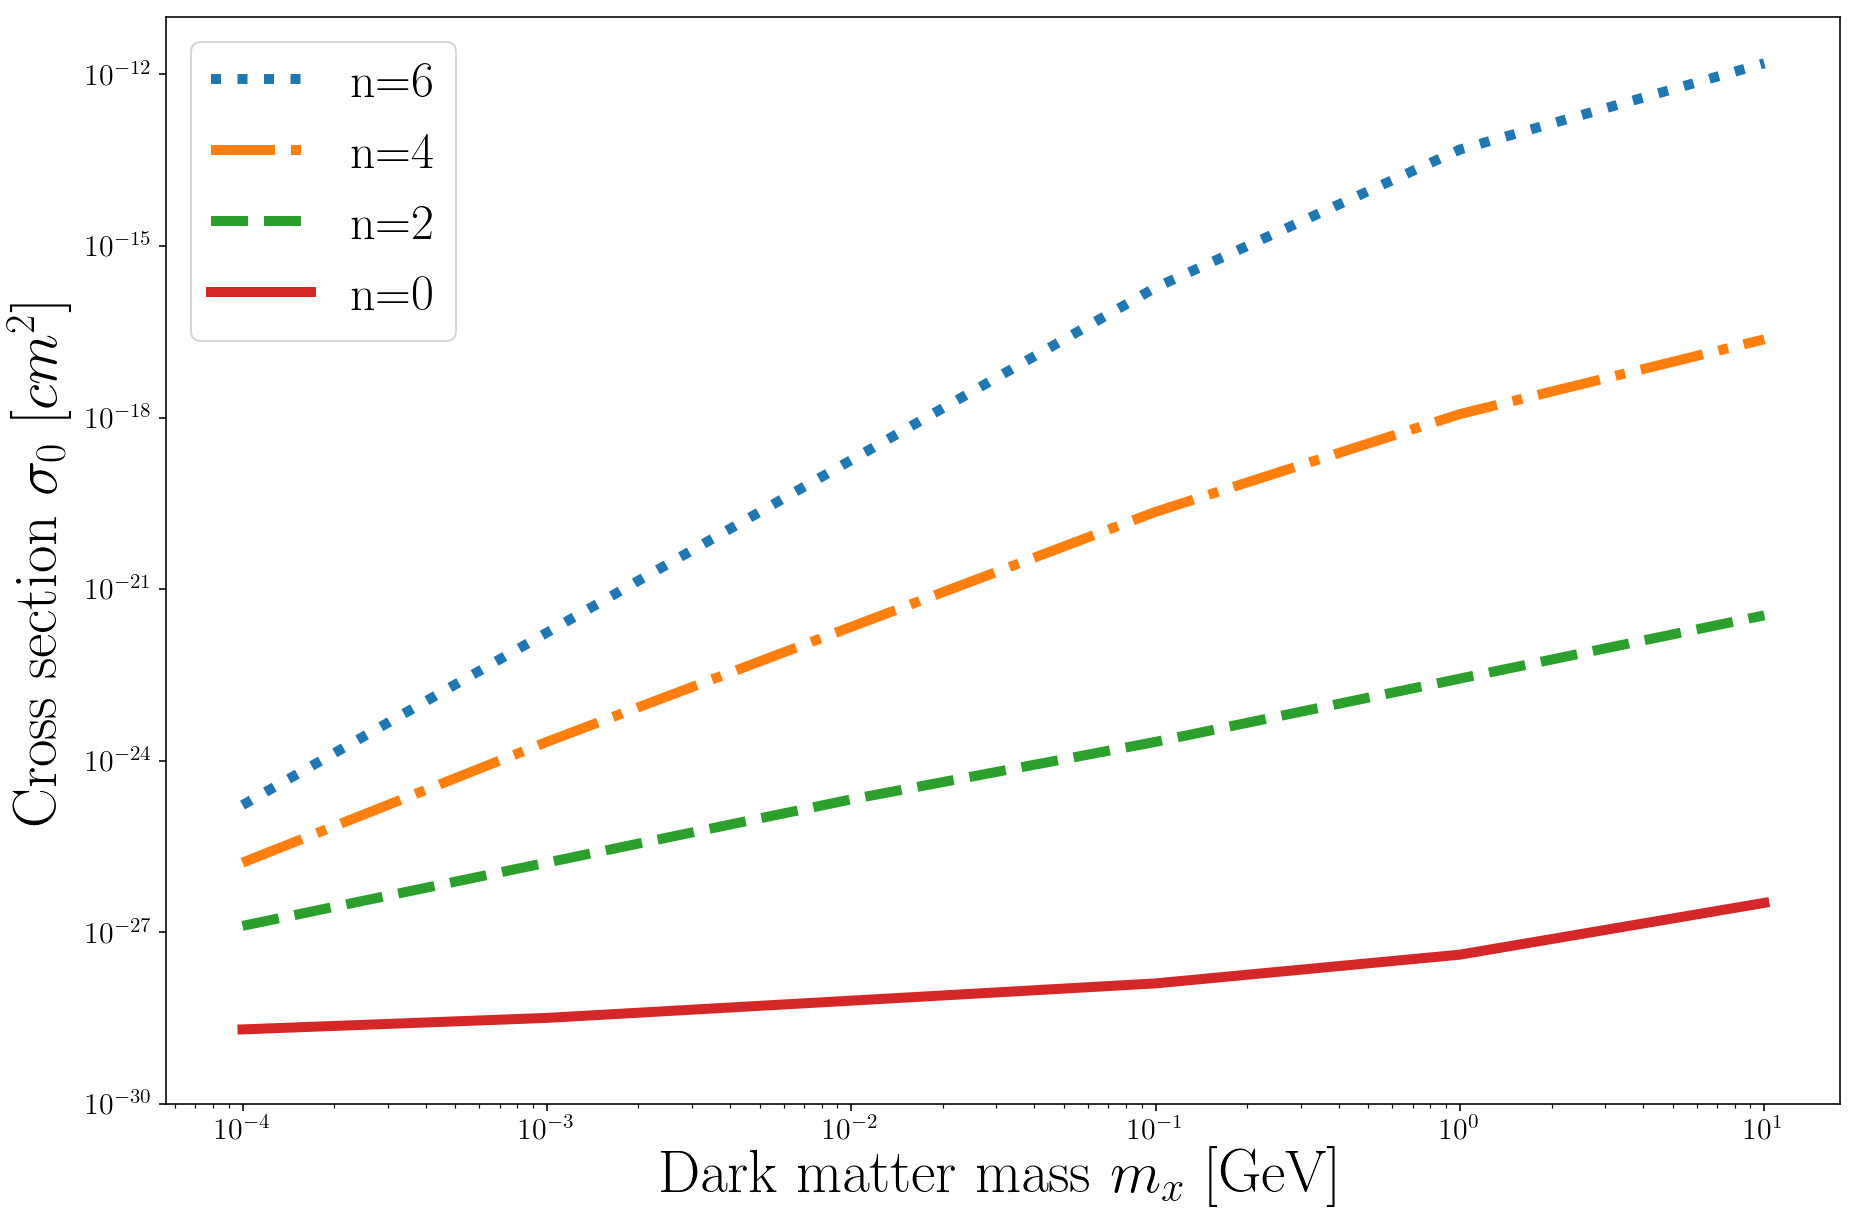

In [30]:
klim = mhm2khm(3*10**8)
# klim=0.1
plt.figure(figsize=(15,10))

plt.loglog(masses, sig(klim,6.), label="n=6",linewidth=5,linestyle=':')
plt.loglog(masses, sig(klim,4.), label="n=4",linewidth=5,linestyle='-.')
plt.loglog(masses, sig(klim,2.), label="n=2",linewidth=5,linestyle='--')
plt.loglog(masses, sig(klim,0.), label="n=0",linewidth=5)

# plt.title(r"Analytical", fontsize=20)
plt.ylabel(r"Cross section $\sigma_0$ [$cm^2$]", fontsize=30)
plt.xlabel(r"Dark matter mass $m_x$ [GeV]", fontsize=30)
plt.legend(fontsize=25)
plt.tick_params(labelsize=15)
plt.ylim(1e-30,1e-11)

plt.savefig("analytical.png")

#### Numerical limits

In [251]:
npow_=6

In [252]:
for m in masses_test:
    if calculate_kcuts(npow=npow_, m=m, z='z1') == -1:
        continue
    sigmas, kcuts, p = calculate_kcuts(npow=npow_, m=m, z='z1')

(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), 

(10.0, (130,), (130,))
(10.0, (130,), (130,))
(10.0, (130,), (130,))
(10.0, (130,), (130,))
(10.0, (130,), (130,))
(10.0, (130,), (130,))
(10.0, (130,), (130,))
(10.0, (130,), (130,))
(10.0, (130,), (130,))
(10.0, (130,), (130,))
(10.0, (130,), (130,))
(10.0, (130,), (130,))
(10.0, (130,), (130,))
(10.0, (130,), (130,))
(10.0, (130,), (130,))
(10.0, (130,), (130,))
(10.0, (130,), (130,))
(10.0, (130,), (130,))
(10.0, (130,), (130,))
(10.0, (130,), (130,))
(10.0, (130,), (130,))
(10.0, (130,), (130,))
(10.0, (130,), (130,))
(10.0, (130,), (130,))
(10.0, (130,), (130,))
(10.0, (130,), (130,))
(10.0, (130,), (130,))
(10.0, (130,), (130,))
(10.0, (130,), (130,))


In [253]:
sigmas_ref = np.logspace(-10,-30,1000)
for m in masses_test:
    ks_filename = 'data/ks_0.25_z0_n{}_m{}.txt'.format(npow_,m)
    if calculate_kcuts(npow=npow_, m=m, z='z1') == -1:
        continue
    sigmas, kcuts, p = calculate_kcuts(npow=npow_, m=m, z='z1')
    ks = fit_fun(sigmas_ref,p)
    np.savetxt(ks_filename, np.vstack((sigmas_ref, ks)).T)

(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), (130,))
(0.001, (130,), 

(0.1, (130,), (130,))
(0.1, (130,), (130,))
(0.1, (130,), (130,))
(0.1, (130,), (130,))
(0.1, (130,), (130,))
(0.1, (130,), (130,))
(0.1, (130,), (130,))
(0.1, (130,), (130,))
(0.1, (130,), (130,))
(0.1, (130,), (130,))
(0.1, (130,), (130,))
(0.1, (130,), (130,))
(0.1, (130,), (130,))
(0.1, (130,), (130,))
(0.1, (130,), (130,))
(0.1, (130,), (130,))
(0.1, (130,), (130,))
(0.1, (130,), (130,))
(0.1, (130,), (130,))
(0.1, (130,), (130,))
(0.1, (130,), (130,))
(0.1, (130,), (130,))
(0.1, (130,), (130,))
(0.1, (130,), (130,))
(0.1, (130,), (130,))
(0.1, (130,), (130,))
(0.1, (130,), (130,))
(0.1, (130,), (130,))
(0.1, (130,), (130,))
(0.1, (130,), (130,))
(0.1, (130,), (130,))
(0.1, (130,), (130,))
(0.1, (130,), (130,))
(0.1, (130,), (130,))
(0.1, (130,), (130,))
(0.1, (130,), (130,))
(0.1, (130,), (130,))
(0.1, (130,), (130,))
(0.1, (130,), (130,))
(0.1, (130,), (130,))
(0.1, (130,), (130,))
(1.0, (130,), (130,))
(1.0, (130,), (130,))
(1.0, (130,), (130,))
(1.0, (130,), (130,))
(1.0, (130

In [254]:
masses0,sigmas0=sigma0_limit(kcut=36,npow=0)
masses2,sigmas2=sigma0_limit(kcut=36,npow=2)
masses4,sigmas4=sigma0_limit(kcut=36,npow=4)
masses6,sigmas6=sigma0_limit(kcut=36,npow=6)

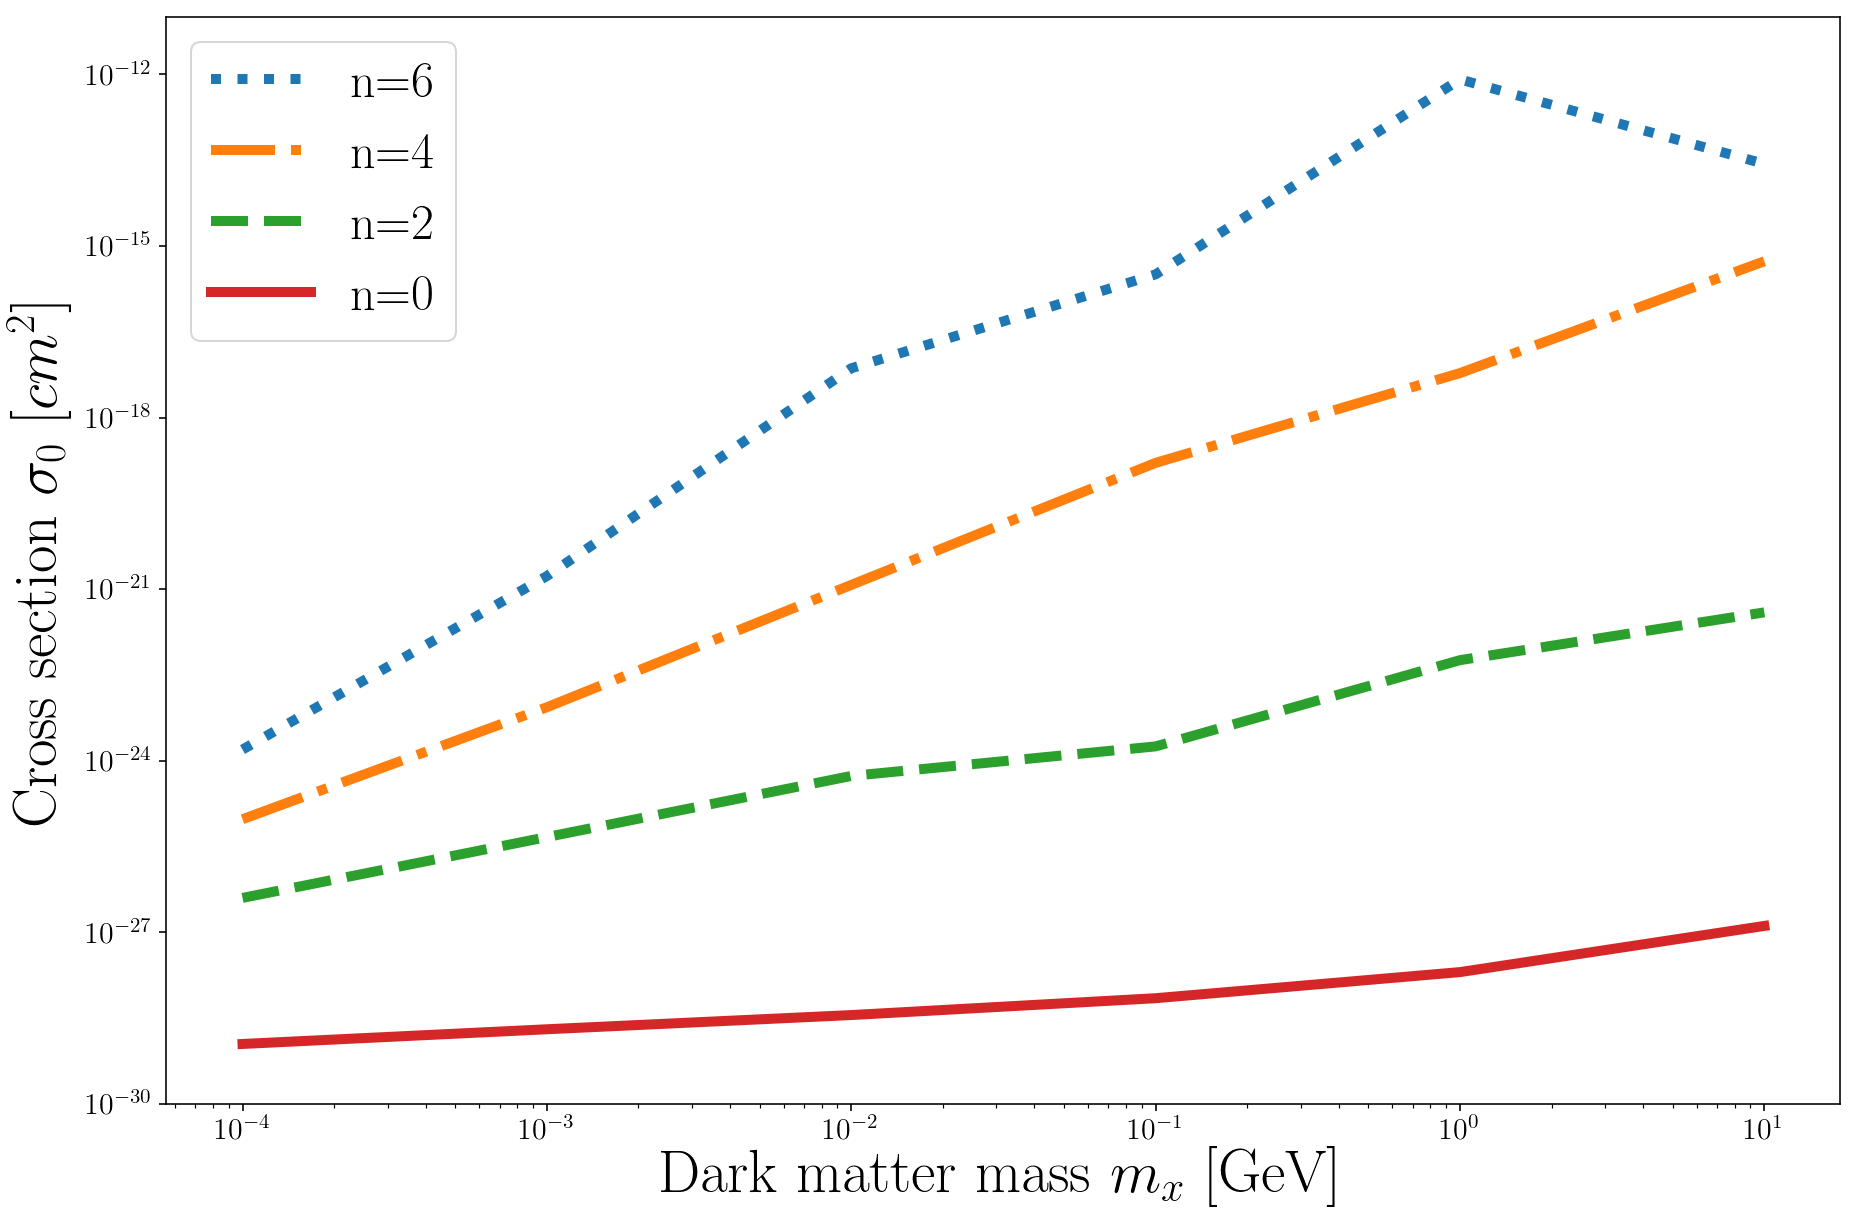

In [255]:
plt.figure(figsize=(15,10))

plt.loglog(masses6,sigmas6, label="n=6",linewidth=5,linestyle=':')
plt.loglog(masses4,sigmas4, label="n=4",linewidth=5,linestyle='-.')
plt.loglog(masses2,sigmas2, label="n=2",linewidth=5,linestyle='--')
plt.loglog(masses0,sigmas0, label="n=0",linewidth=5)

plt.ylabel(r"Cross section $\sigma_0$ [$cm^2$]", fontsize=30)
plt.xlabel(r"Dark matter mass $m_x$ [GeV]", fontsize=30)
plt.legend(fontsize=25)
plt.tick_params(labelsize=15)
plt.ylim(1e-30,1e-11)

plt.savefig("numerical.png")

#### Limits by exclusion curve

In [324]:
def transfer(k,mwdm):
    nu = 1.12
    lambda_fs = (0.049*(mwdm**(-1.11))\
                 *((Omega_m/0.25)**(0.11))*((h/0.7)**1.22))
    alpha = lambda_fs
    transfer = (1+(alpha*k)**(2*nu))**(-5./nu)
    return transfer

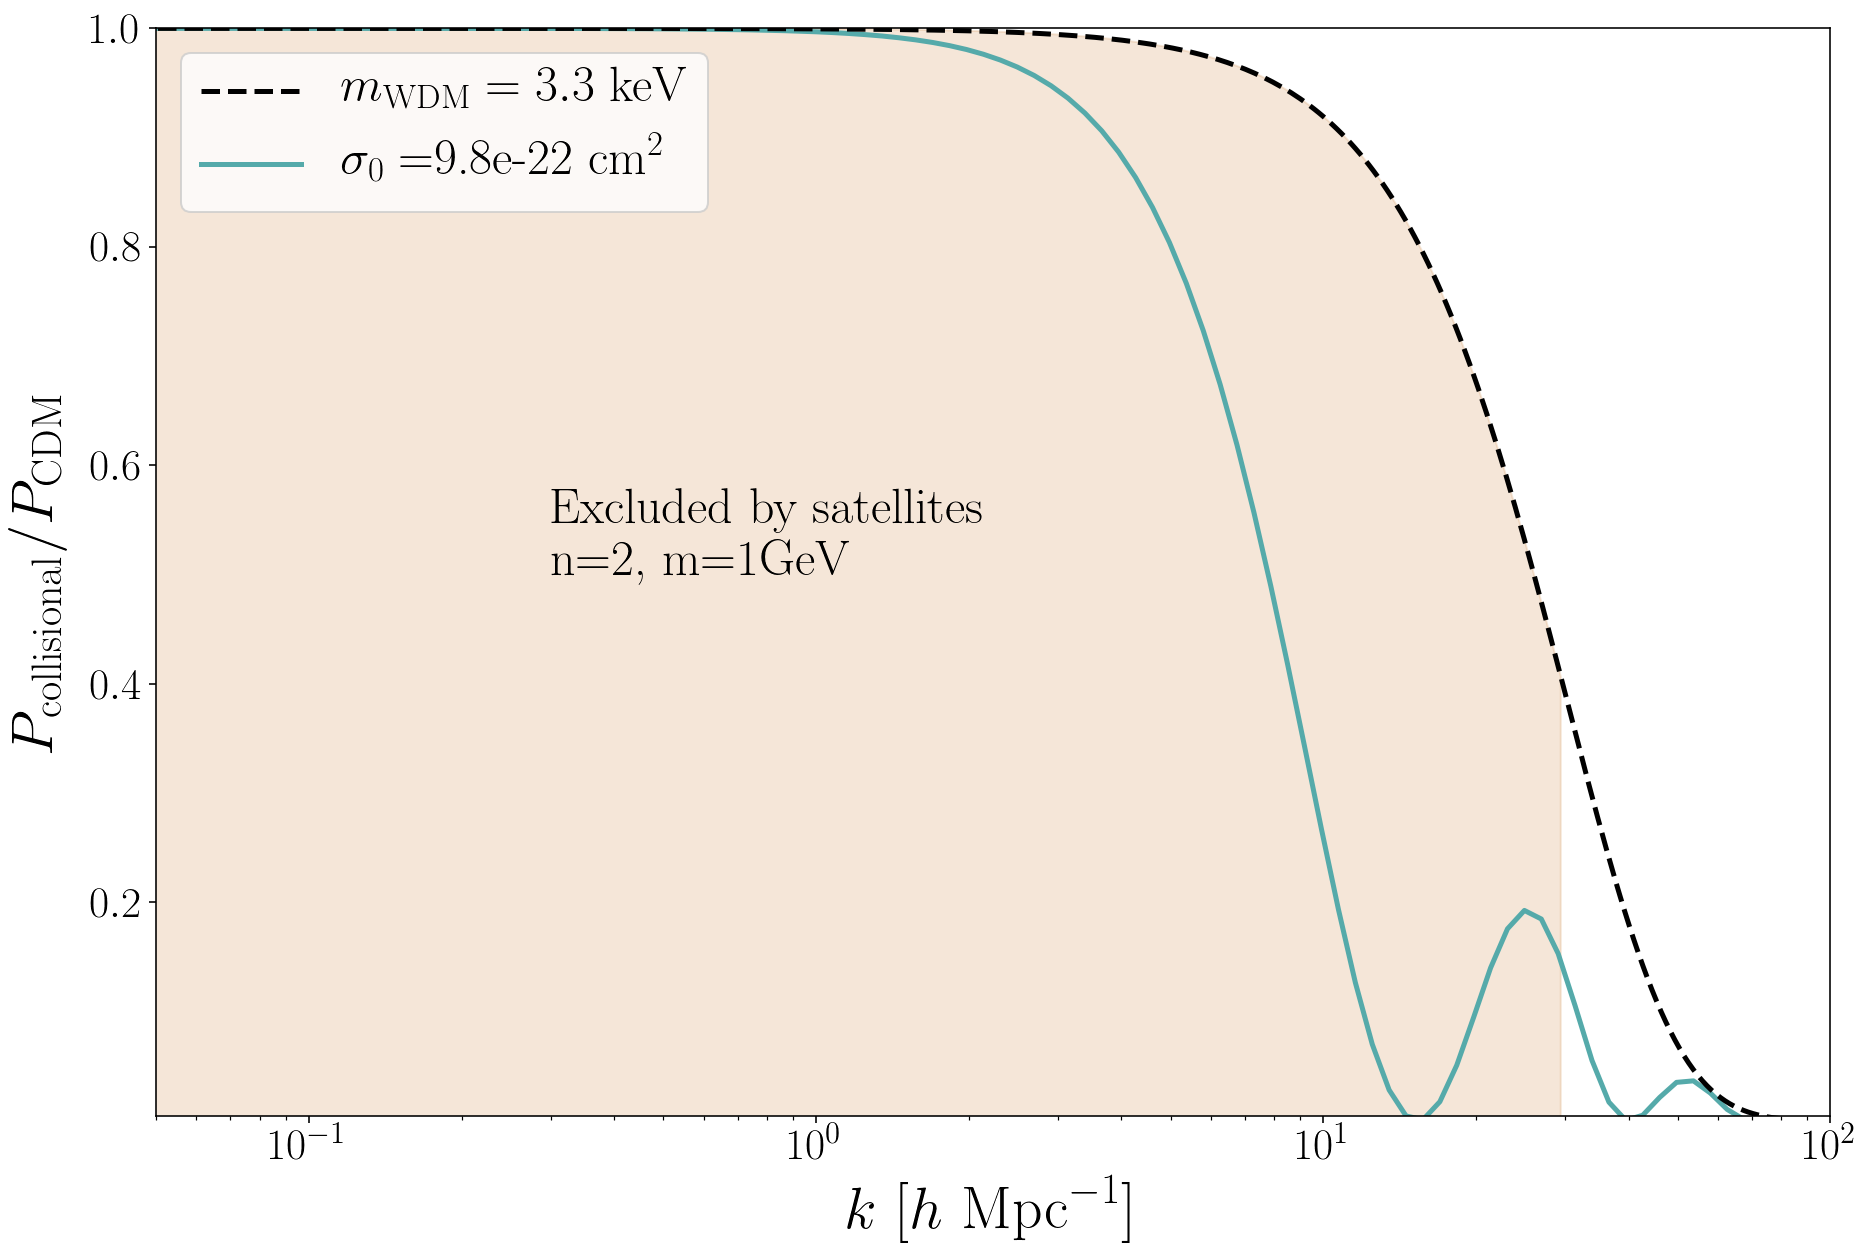

In [354]:
ks2 = np.logspace(-5,4,1000)

plt.figure(figsize=(15,10))
plt.semilogx(ks2,transfer(ks2,3.3)**2,linestyle='--',label=r'$m_{\rm{WDM}} = 3.3\ \rm{keV}$',c='k',lw=2.5,zorder=998)
k1_2,k2_2,sigs_2 = tk(npow=2,m=1,singleSigma=True,
                      sigmas=smallSigs,index=10)
plt.xlim(0.05,1e2)
plt.ylim(0.005,1)
plt.ylabel(r'$P_{\rm{collisional}}/P_{\rm{CDM}}$',fontsize=30,labelpad=8)
plt.xlabel(r'$k$ [$h\ \rm{Mpc}^{-1}$]',fontsize=30)
plt.legend(fontsize=25)
# plt.xticks([1e-1,1e0,1e1,5e1,1e2,1e3,1e4])
# plt.yticks([0.05,0.25,0.5,0.75,1.0])
plt.text(0.3,0.5,"Excluded by satellites\n n=2, m=1GeV",fontsize=25)
plt.tick_params(labelsize=22)
plt.fill_between(np.logspace(-5,4,1000), -10, transfer(ks2,3.3)**2,np.logspace(-5,4,1000) <=30,color='peru',alpha=0.2)

In [356]:
n2_limits = pd.DataFrame({'Mass (GeV)':mass,'$\sigma_0$ conservative ($cm^2$)':sigs2_cons,'$\sigma_0$ super conservative ($cm^2$)':sigs2_uberCons,'$\sigma_0$ progressive ($cm^2$)':sigs2_prog})
n2_limits.to_csv("n2_limits.csv")
n2_limits

,$\sigma_0$ conservative ($cm^2$),$\sigma_0$ progressive ($cm^2$),$\sigma_0$ super conservative ($cm^2$),Mass (GeV)
0,3.500000e-26,1.700000e-27,3.500000e-26,0.0001
1,7.400000e-24,3.600000e-25,1.500000e-23,0.0100
2,1.200000e-21,3.800000e-23,9.800000e-22,1.0000


In [357]:
n4_limits = pd.DataFrame({'Mass (GeV)':mass,'$\sigma_0$ conservative ($cm^2$)':sigs4_cons,'$\sigma_0$ super conservative ($cm^2$)':sigs4_uberCons,'$\sigma_0$ progressive ($cm^2$)':sigs4_prog})
n4_limits.to_csv("n4_limits.csv")
n4_limits

,$\sigma_0$ conservative ($cm^2$),$\sigma_0$ progressive ($cm^2$),$\sigma_0$ super conservative ($cm^2$),Mass (GeV)
0,3.700000e-24,5.600000e-26,4.600000e-24,0.0001
1,8.100000e-20,1.200000e-21,8.300000e-19,0.0100
2,3.500000e-16,5.300000e-18,1.450000e-15,1.0000


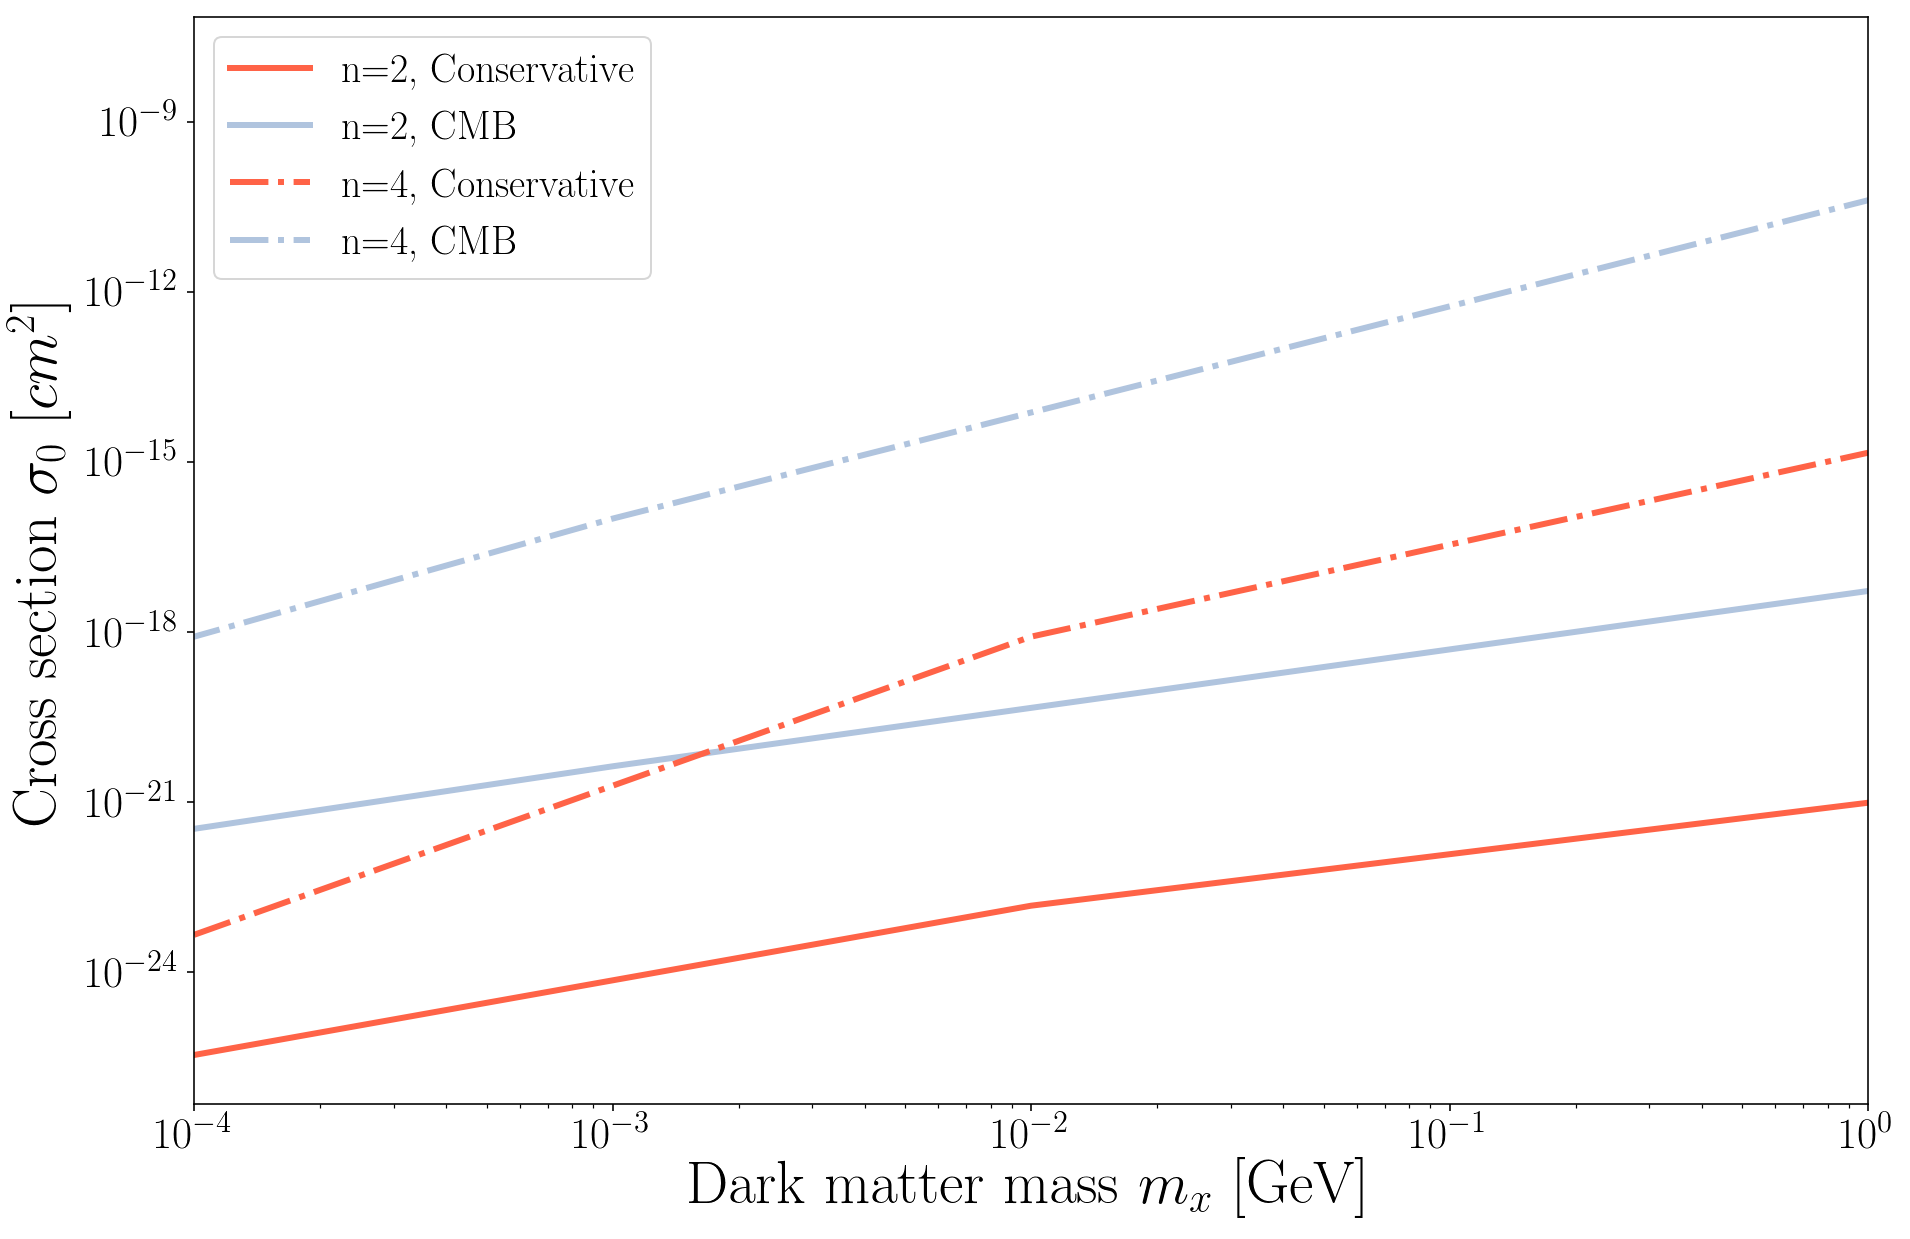

In [355]:
sigs0_prog = [1e-29,2.6e-29,1e-28]
sigs2_prog = [1.7e-27,3.6e-25,3.8e-23]
sigs4_prog = [5.6e-26,1.2e-21,5.3e-18]
sigs6_prog = [9.1e-25,2.8e-18,6e-13]

sigs0_cons = [1e-28,4.2e-28,2.7e-27]
sigs2_cons = [3.5e-26,7.4e-24,1.2e-21]
sigs4_cons = [3.7e-24,8.1e-20,3.5e-16]
sigs6_cons = [2.4e-22,3.6e-16,8e-11]

sigs2_uberCons = [3.5e-26,1.5e-23,9.8e-22]
sigs4_uberCons = [4.6e-24,8.3e-19,1.45e-15]

sigs0_anal = [2e-29,6.4e-29,4.1e-28]
sigs2_anal = [1.30490198e-27,2.12145178e-25,2.73644000e-23]

sigs0_eft = [8.8e-27,2.6e-26,1.5e-25,1.4e-23]
sigs2_eft = [4.2e-23,4.3e-21,5.3e-18,2.2e-15]
sigs4_eft = [1.6e-20,1.0e-16,4.1e-11,9.3e-09]
sigs6_eft = [5.0e-04,1.5e+00]

mass = [0.0001,0.01,1]
mass_eft = [1.5e-5,0.001,1,1000]
mass_eft6 = [1,1000]

plt.figure(figsize=(15,10))
# plt.loglog(mass,sigs0_prog,label="n=0, progressive",linestyle='-',color='lightsteelblue',lw=3)
# plt.loglog(mass,sigs0_cons,label="n=0, conservative",linestyle='-',color='tomato',lw=3)
# plt.loglog(mass_eft,sigs0_eft,label="n=0, eft",linestyle='-',color='khaki',lw=3)

# plt.loglog(mass,sigs2_prog,label="n=2, progressive",linestyle='--',color='lightsteelblue',lw=3)
# plt.loglog(mass,sigs2_cons,label="n=2, conservative",linestyle='--',color='tomato',lw=3)
plt.loglog(mass,sigs2_uberCons,label="n=2, Conservative",linestyle='-',color='tomato',lw=3)
plt.loglog(mass_eft,sigs2_eft,label="n=2, CMB",linestyle='-',color='lightsteelblue',lw=3)

# plt.loglog(mass,sigs4_prog,label="n=4, progressive",linestyle='-.',color='lightsteelblue',lw=3)
# plt.loglog(mass,sigs4_cons,label="n=4, conservative",linestyle='-.',color='tomato',lw=3)
plt.loglog(mass,sigs4_uberCons,label="n=4, Conservative",linestyle='-.',color='tomato',lw=3)
plt.loglog(mass_eft,sigs4_eft,label="n=4, CMB",linestyle='-.',color='lightsteelblue',lw=3)

# plt.loglog(mass,sigs6_prog,label="n=6, progressive",linestyle=':',color='lightsteelblue',lw=3)
# plt.loglog(mass,sigs6_cons,label="n=6, conservative",linestyle=':',color='tomato',lw=3)
# plt.loglog(mass_eft6,sigs6_eft,label="n=6, eft",linestyle='-.',color='khaki',lw=3)

plt.xlim(1e-4,1)
# plt.ylim(1e-25,1e-10)
plt.ylabel(r"Cross section $\sigma_0$ [$cm^2$]",fontsize=30)
plt.xlabel(r"Dark matter mass $m_x$ [GeV]",fontsize=30)
plt.legend(fontsize=20)
plt.tick_params(labelsize=22)
plt.savefig("limits.png")

#### Transfer function business

ValueError: operands could not be broadcast together with shapes (130,) (246,) 

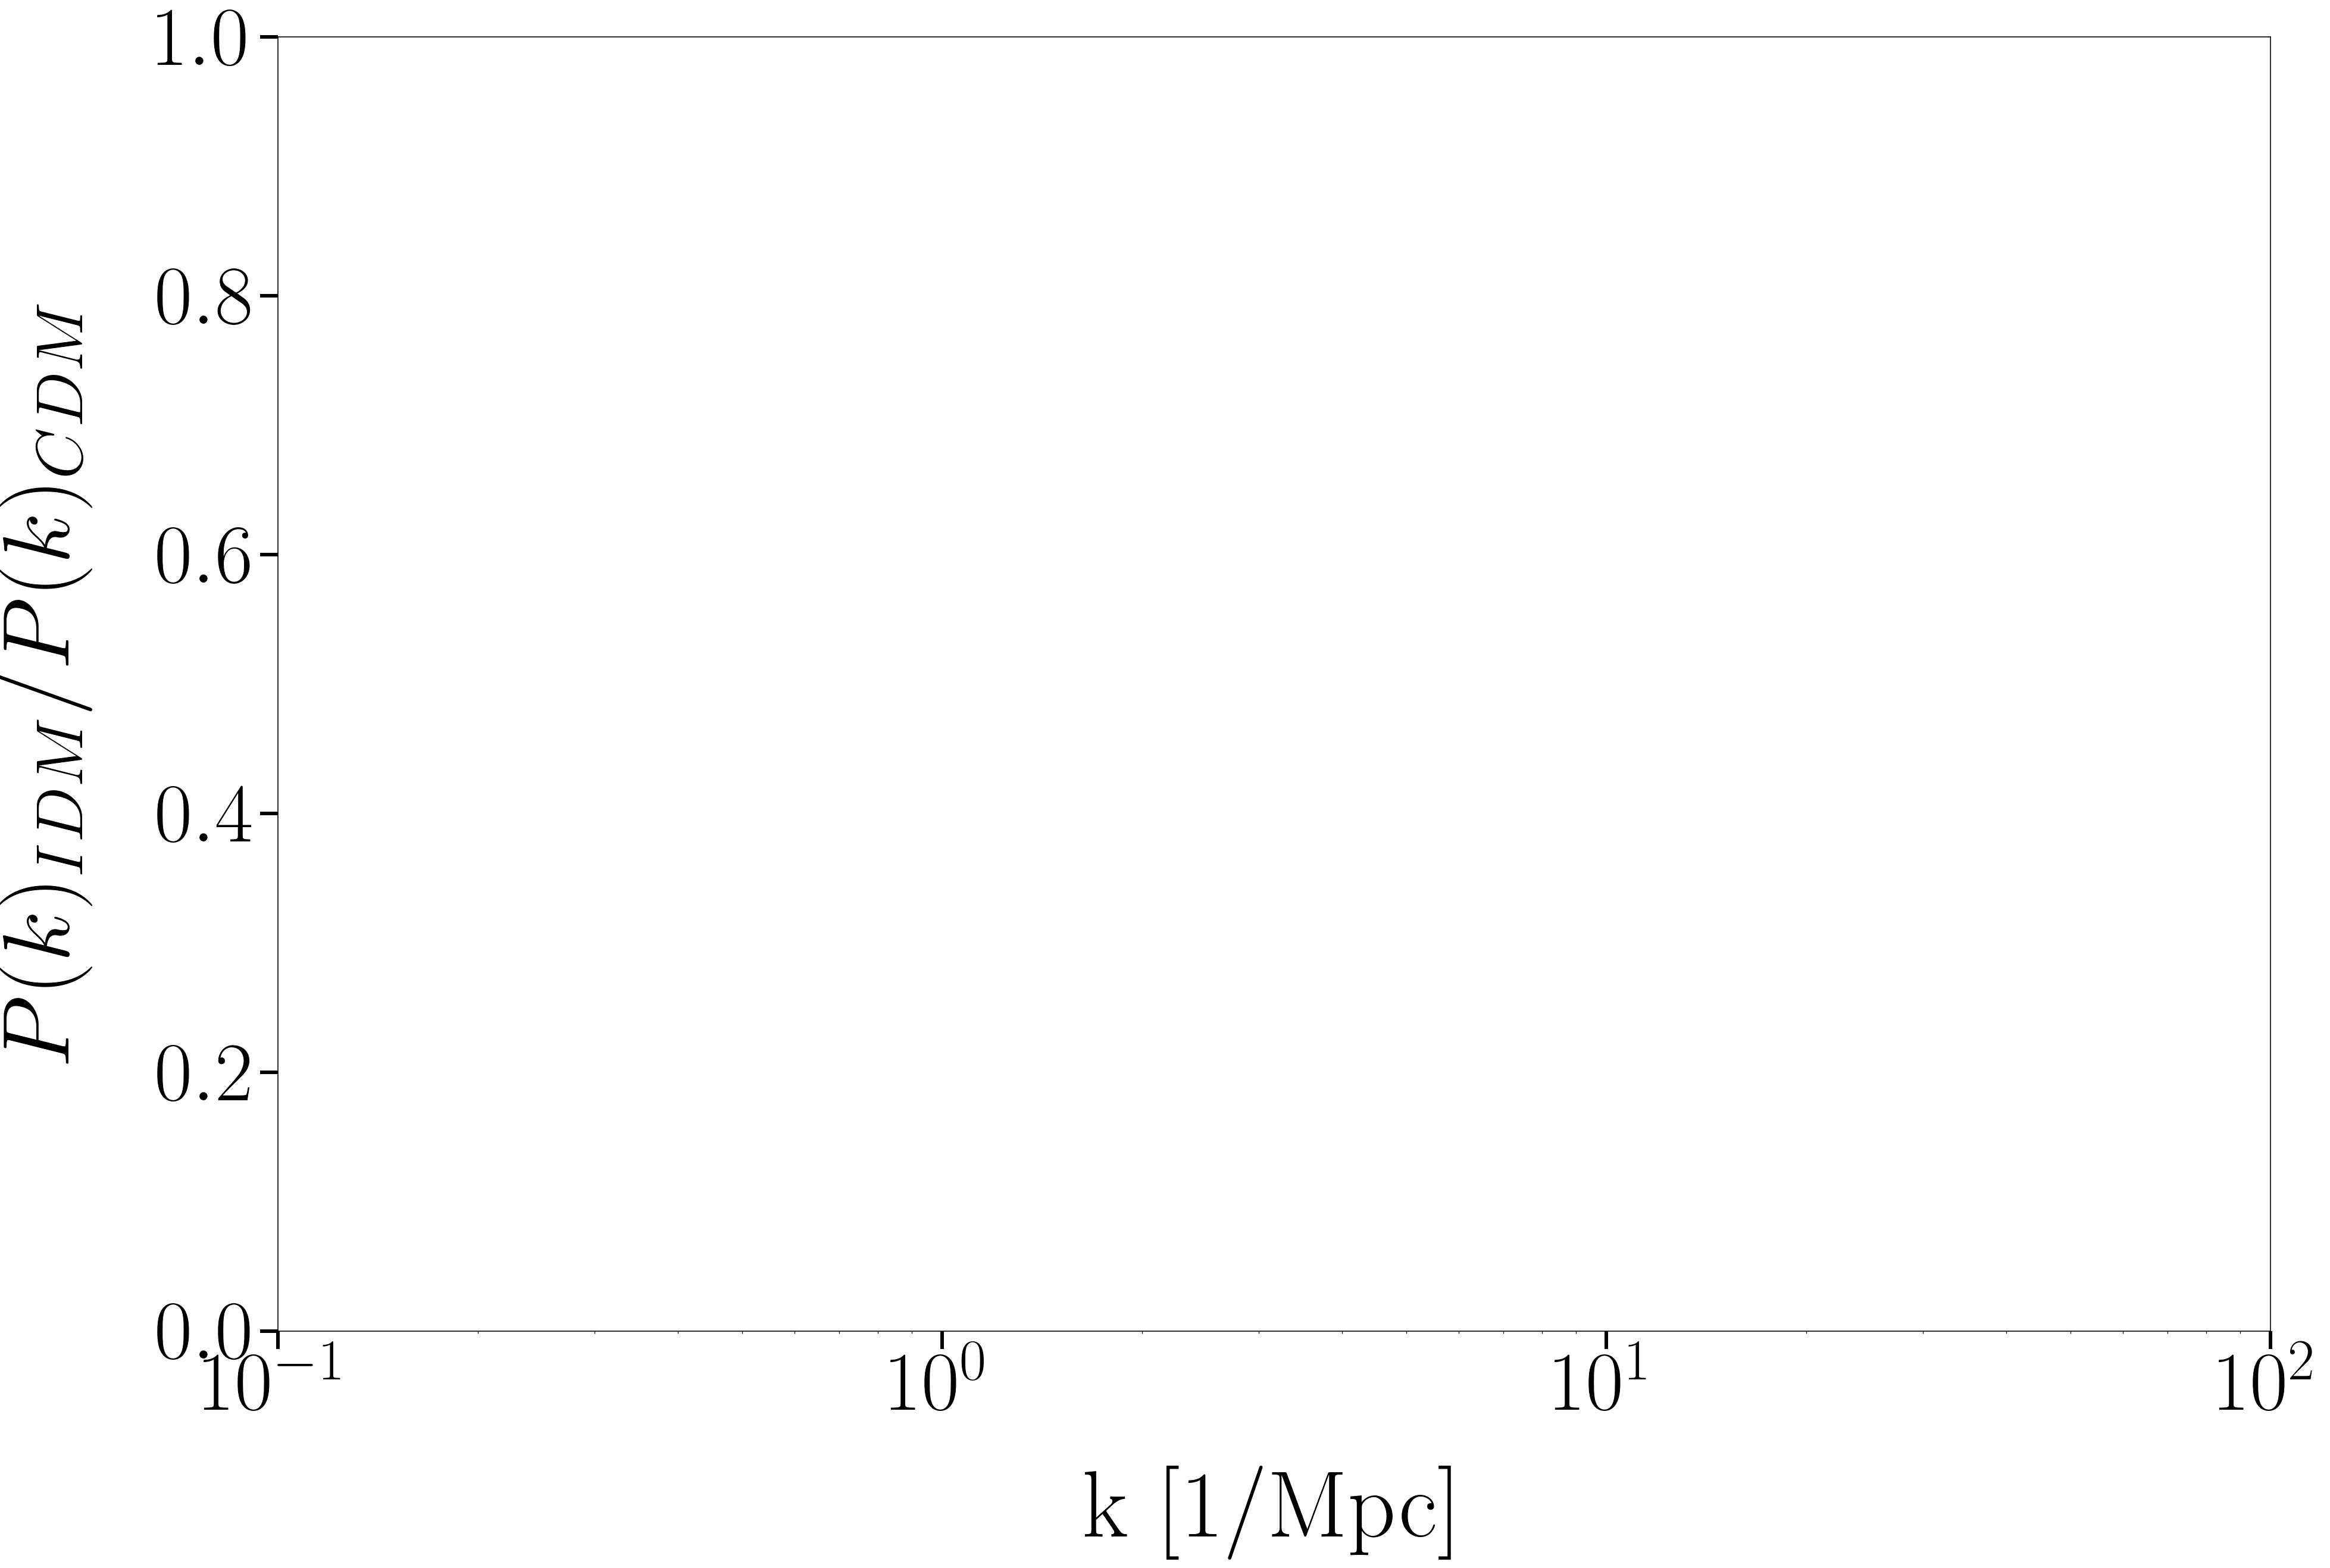

In [250]:
plt.figure(figsize=(30,20))    
plt.xscale('log')
plt.xlabel('k [1/Mpc]',fontsize=30)
plt.ylabel('P(k) residual',fontsize=30)
plt.xlim(1e-1,1e2)
plt.ylim(0,1)
plt.ylabel(r"$P(k)_{IDM}/P(k)_{CDM}$", fontsize=80,labelpad=45)
plt.xlabel(r"k [1/Mpc]", fontsize=80, labelpad=30)
plt.tick_params(labelsize=70,length=15,width=3)

# k1_0,k2_0,sigs_0 = show_pk(npow=0,label="n=0")
k1_2,k2_2,sigs_2 = tk(npow=2,label="n=2",singleSigma=True,index=20)
# k1_4,k2_4,sigs_4 = show_pk(npow=4,label="n=4")
# k1_6,k2_6,sigs_6 = show_pk(npow=6,label="n=6")

plt.axvline(k2_2)
# plt.text(1.2e-1,0,"$m_{\chi}=100$ keV, $n=2$",fontsize=40)

# plt.legend(fontsize=58)
# plt.savefig("pk{}some_secondDownCrossing.pdf".format(npow),dpi=1000)

In [ ]:
# Must pass multiple simgas to tk for this to make any sense

plt.figure(figsize=(15,10))    
plt.loglog(sigs_2,k1_2,color='r',label="$k_1$")
plt.loglog(sigs_2,k2_2,label='$k_2$')
plt.xlim(1e-26,1e-20)
plt.xticks(fontsize=30)
plt.yticks([1e-1,1e0,1e1,1e2],fontsize=30)
plt.xlabel("$\sigma_0$"+r"$\textrm{ [cm}^2]$"
,fontsize=40)
plt.ylabel('k [1/Mpc]',fontsize=40)
plt.legend(fontsize=30)

In [ ]:
plt.figure(figsize=(15,10))    

plt.scatter(sigs_2,k1_2/k2_2,s=50,color='red',alpha=0.6,label='n=2')
# plt.scatter(sigs_4,k1_4/k2_4,s=50,color='b',alpha=0.6,label='n=4')
# plt.scatter(sigs_6,k1_6/k2_6,s=50,color='orange',alpha=0.6,label='n=6')

plt.xscale('log')
plt.xlim(1e-26,1e-20)
plt.ylim(0,0.7)
plt.xlabel("$\sigma_0$"+r"$\textrm{ [cm}^2]$",fontsize=40)
plt.ylabel('$k_1/k_2$',fontsize=40)
plt.xticks(fontsize=20)
plt.yticks([0.10,0.20,0.30,0.40,0.50,0.60,0.70],fontsize=20)
plt.legend(fontsize=30)